# **Space X  Falcon 9 First Stage Landing Prediction**


### Final part: Machine Learning Prediction


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [223]:
!pip install numpy
!pip install pandas
!pip install seaborn


We will import the following libraries for the lab


In [224]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


### Note: What is confusion matrix ? 
A confusion matrix is a performance measurement tool used in machine learning to evaluate the quality of a classification model. It's particularly useful for binary classification problems.
The concepts that we need to understand here are as follow: 
1. TP: model accurately predicted positive class.
2. TN: model accurately predicted nagative class.
3. FP/Type 1 error: The model in-accurately predicted positive class when it was actually negative. 
4. FN/Type2 error: The model in-accurately predicted nagative class when it was actually positive. 
5. Accuracy : The proportion of correctly classified data points (TP and TN) out of the total.Formula: (TP + TN) / (TP + TN + FP + FN)
6. Precision((Positive Predictive Value, PPV)): Precision measures the accuracy of the positive class predictions. Formula: TP / (TP + FP)
7. Recall(True Positive Rate, Sensitivity): Recall measures the model's ability to capture all actual positive instances.Formula: TP / (TP + FN)
8. F1-Score:The F1-Score is the harmonic mean of precision and recall, providing a balanced measure of model performance.Formula: 2 * (Precision * Recall) / (Precision + Recall)
9. False Positive Rate (FPR): FPR measures the proportion of false alarms or Type I errors. Formula: FP / (TN + FP)

10. False Negative Rate (FNR):
FNR measures the proportion of missed opportunities or Type II errors.
Formula: FN / (TP + FN)


In [225]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [226]:
#import requests
#import io

#URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
#response = requests.get(URL1)

#if response.status_code == 200:
    #text1 = io.StringIO(response.text)
    #data = pd.read_csv(text1)
#else:
   #print("Failed to fetch data. Status code:", response.status_code)
   
   # Let's directly load data from the csv file that we created in earlier parts. I am going to use oart2.csv file
data = pd.read_csv("dataset_part_2.csv")
data.head()
   

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [227]:
import requests
import io
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = requests.get(URL2)
if resp2.status_code == 200:
    text2 = io.StringIO(resp2.text)
    X = pd.read_csv(text2)
else:
    print("Failed to fetch data. Status code:", resp2.status_code)





In [228]:
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


#### TASK  1
##### Why do we need to convert class column into NumPy array ? 
Many machine learning libraries, including scikit-learn, require input data to be in the form of NumPy arrays. Therefore, if you want to build a machine learning model using your data, you need to convert it to NumPy arrays.


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [229]:
Y = data['Class'].to_numpy()
Y = pd.Series(Y)


#### TASK  2
##### The concepts that you need to understand are as follow:
1. Normalization: Scaling data to a common range, typically between 0 and 1.
2. Standardization: Transforming data to have a mean of 0 and a standard deviation of 1.This process is also known as "z-score" standardization.
3. Z-Score: The z-score of a data point is a measure of how many standard deviations it is away from the mean. It's calculated as (value - mean) / standard deviation.



Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [230]:

# Define the StandardScaler
transform = preprocessing.StandardScaler()

# Standardize the data and reassign it to the variable X
# The fit_transform method It calculates the mean and standard deviation for each feature in the data stored in X.
#It standardizes the data based on the calculated means and standard deviations, 
# resulting in a NumPy array where each feature has a mean of 0 and a standard deviation of 1.
X = transform.fit_transform(X)


We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. 

In [231]:

# Split the data into training and test sets
# The random_state parameter is used to control the randomness of the data split
# when using train_test_split
X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=2)


we can see we only have 18 test samples.


In [232]:
Y_test.shape
Y_train.shape
X_train.shape
X_test.shape

(18, 83)

#### TASK  4
##### The things that you need to understand : 
##### Hyperparameters: hyperparameters are parameters of a machine learning model that are not learned from the training data but are set before the training process begins.
##### It Controls Model Behavior: Hyperparameters control various aspects of the model's behavior, such as complexity, regularization strength, convergence criteria, and optimization methods.
##### Tuning: Hyperparameter tuning involves finding the optimal values for these hyperparameters to maximize the model's performance on a specific task. It's a crucial part of building effective machine learning models.
##### Overfitting :
Overfitting occurs when a model fits the training data extremely well but fails to generalize to unseen data(test data)
##### Underfitting: 
it occurs when the model can not generalize the testing result. mostly because of less amount of training data.
##### Regularization(c): Two common types of regularization are L1 (Lasso) and L2 (Ridge) regularization. They differ in the way they penalize the coefficients:
L1 regularization adds the absolute values of the coefficients to the loss function.
L2 regularization adds the squares of the coefficients to the loss function.
##### Penalty: L1/L2 
##### Solver: The "solver" is the optimization algorithm used to fit the logistic regression model to the training data. Logistic regression aims to find the best set of coefficients that minimizes a loss function.
Different solvers use different optimization techniques and may be more or less suitable for specific datasets or problem types.
'lbfgs' (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) is one of the optimization algorithms available for logistic regression. It's a good choice for small to medium-sized datasets.
The choice of solver can affect the training time and the convergence of the model. It's another hyperparameter that can be tuned to optimize model performance.
##### Loss function: 
The loss function is a critical component in training machine learning models, including logistic regression. It quantifies the difference between the predicted values (output of the model) and the actual target values in the training data. The goal during training is to minimize the loss function, which means making the model's predictions as close as possible to the true values. 
#### Loss Function in Logistic Regression:
In logistic regression, the most common loss function is the logistic loss (or log loss) function, also known as the cross-entropy loss. The logistic loss is used when the target variable is binary (e.g., 0 or 1). It measures the error between the predicted probabilities and the true binary labels.
#### Formula: L(y, p) = -[y * log(p) + (1 - y) * log(1 - p)]
here , y is the true binary label (0 or 1) for the data point.
p is the predicted probability that the data point belongs to class 1.
The loss function penalizes the model more when it makes confident wrong predictions (i.e., when p is far from y).


#### Importance of the Loss Function:

The loss function guides the model during training by providing feedback on how well it's doing.
Minimizing the loss function helps the model make more accurate predictions, especially for binary classification tasks.
The choice of the loss function can have a significant impact on model performance and the types of errors it makes.

#### Grid Search: 
Grid Search is a hyperparameter tuning technique used to systematically search for the best combination of hyperparameters for a machine learning model. It involves specifying a set of hyperparameters and their potential values, and then evaluating the model's performance for all possible combinations.
The primary use of Grid Search is to find the combination of hyperparameters that results in the best model performance, as measured by a chosen evaluation metric (e.g., accuracy, F1-score, or mean squared error).

#### Cross-Validation (CV): 
Grid Search often uses cross-validation to assess model performance. Cross-validation involves splitting the training data into multiple subsets (folds) and training and evaluating the model on each fold. The cv parameter in Grid Search specifies the number of cross-validation folds to use. Common values are 5 or 10.

#### Hyperparameter Tuning: The GridSearchCV object, configured with a hyperparameter grid and a scoring metric, iteratively tests all possible combinations of hyperparameters on the training data using cross-validation. It trains and evaluates the model for each combination.

#### The score:  is a method used to evaluate the model's performance on a specified evaluation metric. The best_score represents the highest score achieved during the hyperparameter tuning process.

Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a logistic regression object
lr = LogisticRegression()

# Define the hyperparameter grid
parameters = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Create a GridSearchCV object with cross-validation (cv) of 10
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
logreg_cv.fit(X_train, Y_train)

# Access the best hyperparameters and best score
best_params = logreg_cv.best_params_
best_score = logreg_cv.best_score_

# Print the best parameters and best score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [234]:
# Calculate the accuracy on the test data
logreg_accuracy = logreg_cv.score(X_test, Y_test)

# Print the accuracy
print("Accuracy on the test data:", logreg_accuracy)


Accuracy on the test data: 0.8333333333333334


In [235]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Assuming you have the true labels Y_test and predicted labels Y_pred
Y_pred=logreg_cv.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

accuracy = accuracy_score(Y_test, Y_pred)
accuracy
 

0.8333333333333334

In [236]:
precision = precision_score(Y_test, Y_pred)
precision

0.8

Here , a precision of 0.8 means that when the model predicts positive (e.g., class 1), it is correct 80% of the time. In other words, out of all the instances the model predicted as positive, 80% of them are true positives (correctly predicted positives), and 20% of them are false positives (incorrectly predicted positives).

In [237]:
recall = recall_score(Y_test, Y_pred)
recall

1.0

From above we got recall 1 that means that a  model has achieved perfect recall on the test data. In other words, it means that the model correctly identified all the positive instances in the test dataset without any false negatives.

In [238]:
# False Positive Rate
fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
fpr

0.5

Here , An FPR of 0.5 means that 50% of actual negatives are being incorrectly classified as positives by the model.

In [239]:
# False Negative Rate
fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
fnr

0.0

Lets look at the confusion matrix:


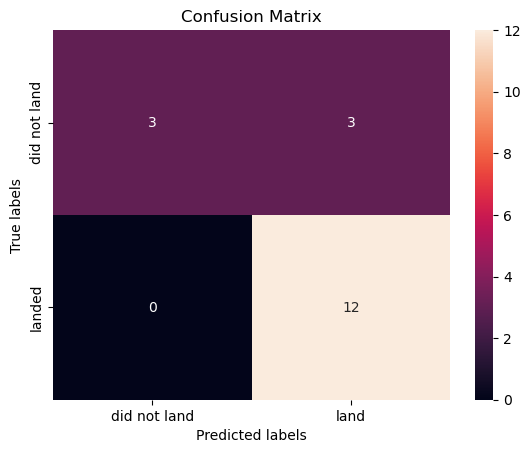

In [240]:
yhat=logreg_cv.predict(X_test)
# Y_test is the actual test data
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


#### Additional Information about Kernel 
The choice of kernel determines the transformation applied to the input features. SVM can use different kernels, and each kernel has its own hyperparameters. The common SVM kernels are:

Linear: No additional hyperparameters.
RBF (Radial Basis Function): Requires a hyperparameter gamma.
Polynomial: Requires hyperparameters degree and coef0.
Sigmoid: Requires hyperparameters gamma and coef0.
#### Gamma (gamma): 
The gamma hyperparameter is specific to the RBF kernel and controls the shape of the decision boundary. A small gamma results in a smoother, more flexible decision boundary, while a large gamma results in a more complex and tighter decision boundary.
#### Advantage of using polynomial kernel in a Support Vector Machine :
Flexibility: The polynomial kernel can capture more complex decision boundaries than the linear kernel. It allows the SVM to model non-linear relationships between features more effectively. This is particularly useful when the data is not linearly separable.

Better Handling of Non-Linearity: When your data has non-linear patterns or clusters, the polynomial kernel can fit the decision boundary to the data's curvature. It can capture more intricate shapes, such as curves or loops, that a linear kernel cannot handle.

Customizable Complexity: The polynomial kernel allows you to control the complexity of the decision boundary by adjusting the degree of the polynomial (a hyperparameter). A higher polynomial degree can result in a more complex boundary, while a lower degree results in a simpler one. This flexibility enables you to tailor the model to the specific complexity of your data.

Feature Engineering: In some cases, the polynomial kernel can help avoid the need for extensive feature engineering. By increasing the polynomial degree, you can create higher-dimensional feature representations that can make previously inseparable data linearly separable.

#### np.logspace(start, stop, num):
is a NumPy function that generates a sequence of numbers spaced evenly on a logarithmic scale. The parameters have the following meanings:

start: The power of 10 for the first value in the sequence.
stop: The power of 10 for the last value in the sequence.
num: The number of values to generate in the sequence.


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [241]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
# Create a GridSearchCV object with cross-validation (cv) of 10
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [242]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [243]:
# Calculate the accuracy on the test data
svm_accuracy = svm_cv.score(X_test, Y_test)

# Print the accuracy
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8333333333333334


Let's check false positive rate and false negative rate .


In [244]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
y_pred = svm_cv.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
accuracy


0.8333333333333334

In [245]:
recall = recall_score(Y_test,y_pred)
recall

1.0

In [246]:
precision = precision_score(Y_test,y_pred)
precision

0.8

In [247]:
# False Positive Rate
fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
fpr

0.5

In [248]:
# False Negative Rate
fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
fnr

0.0

We can plot the confusion matrix


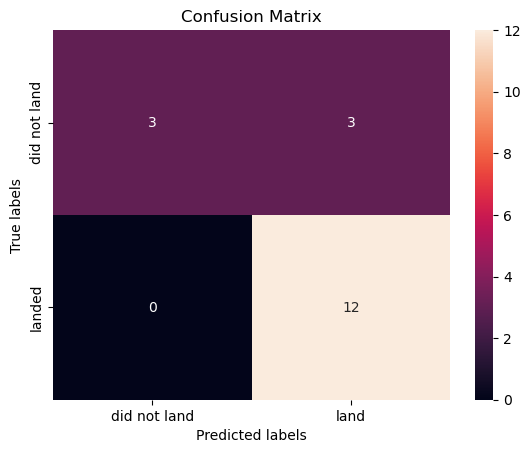

In [249]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

As we can see that not a significant change in model performance using SVM and GridSearch hyperparameter tuning .

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


As we know that Hyperparameters control the behavior and complexity of the model.
#### Let's dive deeper into hyperparametes used for decision tree model. 
1. criterion:
This hyperparameter specifies the criterion used to measure the quality of a split. In decision trees, two common criteria are 'gini' and 'entropy'. 'Gini' measures impurity based on the Gini impurity, while 'entropy' uses information gain based on the entropy of the target variable. You can choose one or both criteria to test which performs better for your problem.

2. splitter:
The splitter hyperparameter determines the strategy used to choose the split at each node. You can choose between 'best' and 'random'. 'Best' selects the best split, while 'random' chooses a random split. It's often used to control overfitting by introducing randomness in the tree's construction.

3. max_depth:
max_depth sets the maximum depth of the decision tree. A smaller value restricts the depth, which can prevent overfitting. The values in the list [2 * n for n in range(1, 10)] generate a range of depths from 2 to 18 (even numbers).

4. max_features:
This hyperparameter determines the number of features to consider when looking for the best split. 'Auto' means all features, and 'sqrt' means the square root of the total number of features. It can help control the model's complexity and reduce overfitting.

5. min_samples_leaf:
min_samples_leaf sets the minimum number of samples required to be in a leaf node. It can prevent the creation of very small leaf nodes, which may lead to overfitting. The values in the list [1, 2, 4] specify different minimum sample leaf sizes.

6. bmin_samples_split:
min_samples_split sets the minimum number of samples required to split an internal node. A smaller value may lead to more complex trees, while a larger value may simplify the tree structure.

#### Entropy: 
Entropy is a concept from information theory and statistics that measures the level of uncertainty, randomness, or disorder in a system. In the context of machine learning, entropy is often used in decision trees, particularly for the decision tree's splitting criterion.

In the context of decision trees:

Entropy measures the impurity or disorder of a set of data points (samples).
It quantifies how mixed the target variable's values are within a dataset.
Lower entropy indicates less disorder or impurity, while higher entropy suggests greater disorder.
Mathematically, the entropy of a set S with respect to a binary classification problem (e.g., binary outcome, e.g., 0 or 1) is calculated as:
Entropy(S) = -p1log2(p1)  -p2log2(p2)
where 
p1 is the proportion of data points in class 1 (positive class).
p2 is the proportion of data points in class 2 (negative class).
The formula calculates the entropy by summing over the weighted information content of each class.

When all data points in the set belong to a single class (i.e., 
p1 = 1 or p2 = 1), the entropy is 0, indicating no disorder. When data points are evenly distributed between the two classes (i.e.p1=p2=0.5), the entropy is at its maximum, indicating maximum disorder.
In the context of decision tree splitting, the entropy is used to measure how well a particular split separates the data into subsets with less disorder (lower entropy). The goal is to find splits that minimize entropy, leading to more homogeneous subsets and better decision tree predictions.

In [250]:


# Define the hyperparameter grid
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
# Create a decision tree classifier object
tree = DecisionTreeClassifier()

# Create a GridSearchCV object with cross-validation (cv) of 10
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

# Access the best hyperparameters and best score
best_params = tree_cv.best_params_
best_score = tree_cv.best_score_

# Print the best parameters and best score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Best Score: 0.8767857142857143


/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  Fil

## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [251]:
# Calculate the accuracy on the test data
tree_accuracy = tree_cv.score(X_test, Y_test)

# Print the accuracy
print("Accuracy on Test Data:", tree_accuracy)


Accuracy on Test Data: 0.8888888888888888


In [252]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
y_pred = tree_cv.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.8888888888888888

In [253]:
recall = recall_score(Y_test, y_pred)
recall


1.0

In [254]:
precision = precision_score(Y_test, y_pred)
precision

0.8571428571428571

In [255]:
# False Positive Rate
fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
fpr

0.3333333333333333

As we can see that this model accuracy score is close to 67% that means model does not fit our training data perfectly . also false positive rate is 1. it means that 100% of the instances that are actually negative are being incorrectly classified as positive by the classification model. We can see in the following confusion matrix graph.

We can plot the confusion matrix


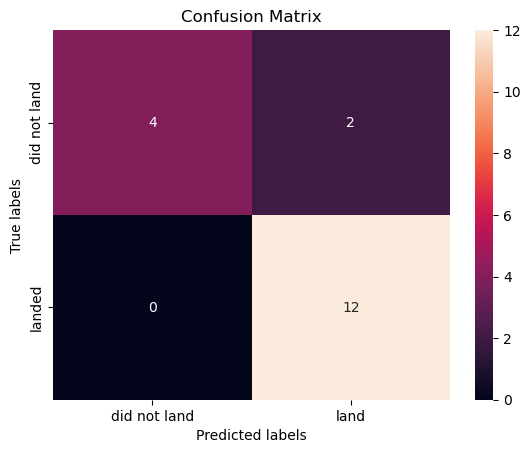

In [256]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)


#### Using Random Forest classifier 

In [257]:
# Step 4: Define a parameter grid for hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Step 5: Create a Random Forest model
rf_model = RandomForestClassifier(random_state=2)

# Step 6: Use GridSearchCV to perform hyperparameter tuning
rf_cv = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

# Step 7: Fit the model to the training data
rf_cv.fit(X_train, Y_train)

# Step 8: Evaluate the model's performance on the testing data
rf_best_model = rf_cv.best_estimator_
Y_pred = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(Y_test, Y_pred)

# Print the best hyperparameters and accuracy
best_params = rf_cv.best_params_
print("Best Hyperparameters:", best_params)
print("Accuracy on the test data:", accuracy)
 





Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy on the test data: 0.8888888888888888


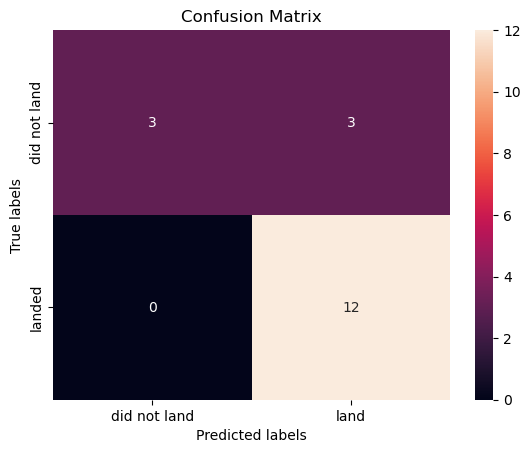

In [258]:
yhat = rf_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Using Gradient Boosting:
Use Case: General Classification and Regression
Explanation: Gradient Boosting is a powerful ensemble learning technique that can be applied to both classification and regression tasks. It combines multiple weak models (usually decision trees) to create a strong predictive model. Gradient Boosting is useful when you want to improve predictive accuracy and reduce overfitting.

Example:
Customer Churn Prediction: Gradient Boosting can be used to predict whether a customer will churn (leave) a subscription service based on various features like usage history, demographics, and behavior.
House Price Prediction: It can be used to predict the selling price of houses based on features like location, size, and amenities.

### Multinomial Naive Bayes (MultinomialNB):
Use Case: Text Classification (Multi-Class Problems)

Explanation: Multinomial Naive Bayes (MultinomialNB) is a specific variant of Naive Bayes that is well-suited for text classification tasks with multiple classes (multi-class problems). It's particularly effective when dealing with text data that is represented as word frequency or term count vectors.

Example:

News Article Categorization: MultinomialNB can be used to categorize news articles into different topics or sections (e.g., sports, politics, entertainment) based on the words and their frequencies in the articles.
Product Review Sentiment Analysis: It can be applied to determine the sentiment (positive, negative, neutral) of product reviews based on the words used in the reviews, where there are multiple classes representing different sentiment categories.

In [259]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting classifier
gb_model = GradientBoostingClassifier()

# Define hyperparameters (if needed)
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    }


gb_cv = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5)
gb_cv.fit(X_train, Y_train)
gb_best_model = gb_cv.best_estimator_

# Fit the model to the training data
gb_model.fit(X_train, Y_train)

# Predict on the testing data
Y_pred_gb = gb_model.predict(X_test)

# Evaluate the model's performance (e.g., accuracy)
accuracy_gb = accuracy_score(Y_test, Y_pred_gb)
print("Accuracy using Gradient Boosting:", accuracy_gb)


Accuracy using Gradient Boosting: 0.8333333333333334


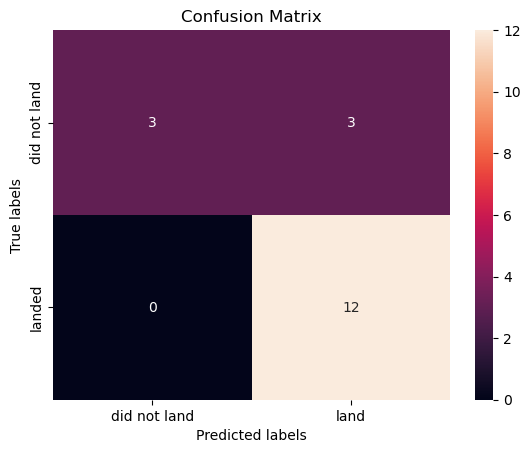

In [260]:
yhat = gb_model.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


#### Distance Matrix : 
#### p = 1 (Manhattan distance or L1 norm):
The Manhattan distance, also known as the L1 norm, calculates the distance between two points as the sum of the absolute differences of their coordinates along each dimension. Mathematically, it can be expressed as follows for two points A(x1, y1) and B(x2, y2) in a two-dimensional space:
Manhattan Distance = |x1 - x2| + |y1 - y2|
In higher dimensions, the Manhattan distance extends this concept to all dimensions, summing the absolute differences along each axis. It is often preferred when you want to measure "city block" distances, where you can only move horizontally and vertically, like navigating city streets.
p = 2 (Euclidean distance or L2 norm):

#### The Euclidean distance,
 also known as the L2 norm, is the standard straight-line distance between two points in Euclidean space. Mathematically, it can be expressed as follows for two points A(x1, y1) and B(x2, y2) in a two-dimensional space:
Euclidean Distance = sqrt((x1 - x2)^2 + (y1 - y2)^2)
The Euclidean distance measures the shortest distance between two points in a straight line and is commonly used when you want to measure "as-the-crow-flies" distances, such as in geometric and spatial applications.
In the context of KNN, you can choose between Manhattan distance (L1 norm) and Euclidean distance (L2 norm) by setting the "p" hyperparameter accordingly. The choice of distance metric should be based on the characteristics of your data and the problem you are trying to solve. In some cases, one distance metric may be more appropriate than the other, depending on the nature of the features and the problem's requirements.

#### Different Hyperparameters: 
#### n_neighbors:
This hyperparameter determines the number of neighbors (data points) that the algorithm considers when making a classification decision for a new data point. It is a crucial parameter in KNN, and different values can significantly affect the model's performance. You're testing values from 1 to 10, which is the range of neighbors to consider.

#### algorithm:
The algorithm hyperparameter specifies the algorithm used to compute the nearest neighbors. You have several options:
'auto': Automatically selects the most appropriate algorithm based on the training data.
'ball_tree': Uses a ball tree data structure for nearest neighbor search.
'kd_tree': Uses a KD-tree data structure for nearest neighbor search.
'brute': Performs an exhaustive search over all data points to find the nearest neighbors. This can be slow for large datasets.

#### p:
The p hyperparameter controls the distance metric used for calculating distances between data points. The choice of distance metric depends on the value of p:
p = 1 corresponds to the Manhattan distance (L1 norm).
p = 2 corresponds to the Euclidean distance (L2 norm).



In [261]:
 # Create a k-nearest neighbors (KNN) classifier object
KNN = KNeighborsClassifier()

# Define the hyperparameter grid
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create a GridSearchCV object with cross-validation (cv) of 10
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
knn_cv.fit(X_train, Y_train)

# Access the best hyperparameters and best score
best_params = knn_cv.best_params_
best_score = knn_cv.best_score_

# Print the best parameters and best score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/base.py", line 706, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 254, in predict
    probabilities = self.predict_proba(X)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/neighbors/_classifi

Best Hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1}
Best Score: 0.8482142857142858


/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/base.py", line 706, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 254, in predict
    probabilities = self.predict_proba(X)
  File "/Users/rabinkarki/.local/lib/python3.9/site-packages/sklearn/neighbors/_classifi

In [262]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [263]:
# Use the knn_cv model to make predictions on the test data
y_pred = knn_cv.predict(X_test)

# Calculate the accuracy of the model on the test data
knn_accuracy = knn_cv.score(X_test, Y_test)

# Print the accuracy
print("Accuracy of the KNN model on the test data:", accuracy)


Accuracy of the KNN model on the test data: 0.8888888888888888


In [264]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
y_pred = knn_cv.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.8333333333333334

In [265]:
recall = recall_score(Y_test, y_pred)
recall
 

1.0

In [266]:
# False Positive Rate
fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
fpr

0.5

We can plot the confusion matrix


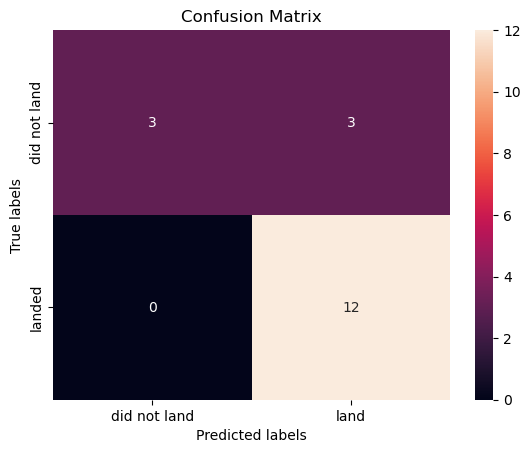

In [267]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


Best Performing Model: Decision Tree
Accuracy: 0.8888888888888888
Least Performing Model: Logistic Regression
Accuracy: 0.8333333333333334


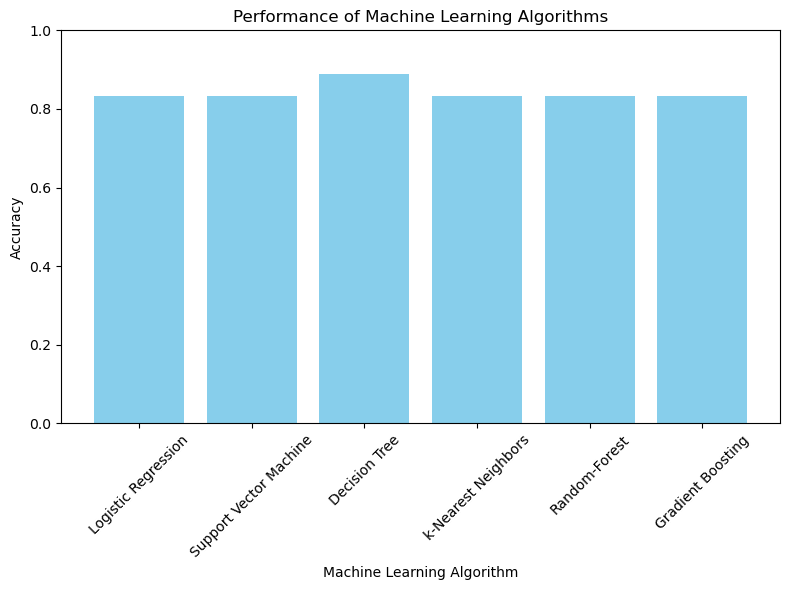

In [268]:
import matplotlib.pyplot as plt

# Define the dictionary with accuracy scores
accuracy_scores = {
    "Logistic Regression": logreg_accuracy,
    "Support Vector Machine": svm_accuracy,
    "Decision Tree": tree_accuracy,
    "k-Nearest Neighbors": knn_accuracy,
    "Random-Forest": rf_accuracy,
    "Gradient Boosting": rf_accuracy
}

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Accuracy')
plt.title('Performance of Machine Learning Algorithms')

# Find the best and least performing models
best_model = max(accuracy_scores, key=accuracy_scores.get)
least_model = min(accuracy_scores, key=accuracy_scores.get)

# Display the best and least performing models
print("Best Performing Model:", best_model)
print("Accuracy:", accuracy_scores[best_model])
print("Least Performing Model:", least_model)
print("Accuracy:", accuracy_scores[least_model])

# Show the bar chart
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set the y-axis limit based on your metric range
plt.tight_layout()
plt.show()


 

As we can see that
1. Best Performing Model: Decision Tree
2. Accuracy: 0.8888888888888888
3. Least Performing Model: Logistic Regression
4. Accuracy: 0.8333333333333334

## Author
Rabin Karki
